In [1]:
import numpy as np 
import csv

import pandas as pd 
import pickle
import matplotlib.pyplot as plt
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, AvgPool2D, BatchNormalization, Reshape
%matplotlib inline

### Data split and preprocess

In [5]:


with open('input\data2.pickle', 'rb') as f:
    data = pickle.load(f, encoding='latin1') 
    
    
num_classes=43
# convert class vectors to binary class matrices
data['y_train'] = to_categorical(data['y_train'], num_classes)
data['y_validation'] = to_categorical(data['y_validation'], num_classes) 
# data['y_test'] = to_categorical(data['y_test'], num_classes) 


data['x_train'] = data['x_train'].transpose(0, 2, 3, 1)
# data['x_train'] = data['x_train'].reshape(86989, 32*32,1)
data['x_validation'] = data['x_validation'].transpose(0, 2, 3, 1)


data['x_test'] = data['x_test'].transpose(0, 2, 3, 1)


for i, j in data.items():
    if i == 'labels':
        print(i + ':', len(j))
    else: 
        print(i + ':', j.shape)

y_test: (12630,)
y_validation: (4410, 43)
x_validation: (4410, 32, 32, 3)
x_train: (86989, 32, 32, 3)
y_train: (86989, 43)
labels: 43
x_test: (12630, 32, 32, 3)


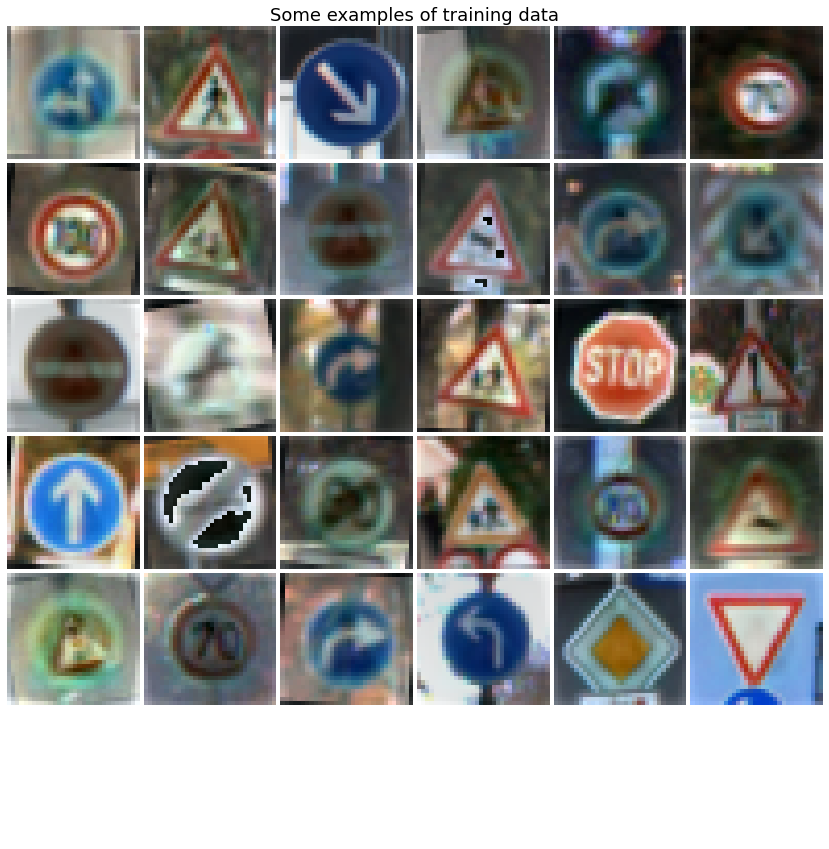

In [6]:
%matplotlib inline

def convert_to_grid(x_input):
    N, H, W, C = x_input.shape
    grid_size = int(np.ceil(np.sqrt(N)))
#     print(grid_size)
    grid_height = H * grid_size + 1 * (grid_size - 1)
    grid_width = W * grid_size + 1 * (grid_size - 1)
#     print(grid_height ,"   ",grid_width )
    grid = np.zeros((grid_height, grid_width, C)) + 255
    next_idx = 0
    y0, y1 = 0, H
    for y in range(grid_size):
        x0, x1 = 0, W
        for x in range(grid_size):
            if next_idx < N:
                img = x_input[next_idx]
                low, high = np.min(img), np.max(img)
                grid[y0:y1, x0:x1] = 255.0 * (img - low) / (high - low)
                next_idx += 1
            x0 += W + 1
            x1 += W + 1
        y0 += H + 1
        y1 += H + 1

    return grid


examples = data['x_train'][:30, :, :, :]
# print(examples.shape)
fig = plt.figure()
grid = convert_to_grid(examples)
plt.imshow(grid.astype('uint8'), cmap='gray')
plt.axis('off')
plt.gcf().set_size_inches(15, 15)
plt.title('Some examples of training data', fontsize=18)
plt.show()
fig.savefig('training_examples.png')
plt.close()

### Build Model

In [8]:
model = Sequential()
model.add(Conv2D(32, kernel_size=3, padding='same', activation='relu', input_shape=(32, 32, 3)))
model.add(MaxPool2D(pool_size=2))#AvgPool2D
model.add(Flatten())#BatchNormalization

# model.add(Dense(43,input_shape=(32,32, 3)))
# model.add(Dropout(0.3))
model.add(Dense(150, activation='relu'))
# model.add(Dropout(0.3))

model.add(Dense(43, activation='softmax'))
model.summary()
model.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 150)               1228950   
_________________________________________________________________
dense_3 (Dense)              (None, 43)                6493      
Total params: 1,236,339
Trainable params: 1,236,339
Non-trainable params: 0
_________________________________________________________________


### Training Data

In [9]:
epochs = 3
h = model.fit(data['x_train'], data['y_train'],
                        batch_size=10, epochs = epochs,
                       validation_split = 0.2,
                        verbose=1)

Epoch 1/3
6960/6960 [==============================] - 55s 8ms/step - loss: 1.5429 - accuracy: 0.5899 - val_loss: 3.2339 - val_accuracy: 0.4712
Epoch 2/3
6960/6960 [==============================] - 63s 9ms/step - loss: 0.4063 - accuracy: 0.8979 - val_loss: 0.2725 - val_accuracy: 0.9404
Epoch 3/3
6960/6960 [==============================] - 58s 8ms/step - loss: 0.2140 - accuracy: 0.9489 - val_loss: 0.1880 - val_accuracy: 0.9565


In [8]:
model.save("Last_data2.h5")

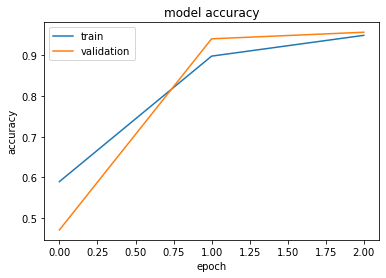

In [11]:

plt.plot(h.history['accuracy'])
plt.plot(h.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')

plt.show()

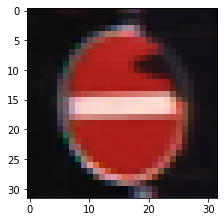

17
Label: No entry


In [15]:
from PIL import ImageTk, Image
image = Image.open('stop.png')
plt.rcParams['figure.figsize'] = (6.5, 3.5) 
image = image.resize((32,32))
plt.imshow(image)
plt.show()


image = np.expand_dims(image, axis=0)
image = np.array(image)
# print(image.shape)
pred = model.predict_classes([image])[0]
print(pred)
# sign = classes[pred+1]
labels = label_text('input/label_names.csv')
print('Label:', labels[pred])

In [10]:
def label_text(file):
    # Defining list for saving label in order from 0 to 42
    label_list = []

    # Opening 'csv' file and getting image's labels
    with open(file, 'r') as f:
        reader = csv.reader(f)
        # Going through all rows
        for row in reader:
            # Adding from every row second column with name of the label
            label_list.append(row[1])
        # Deleting the first element of list because it is the name of the column
        del label_list[0]
    # Returning resulted list
    return label_list